# Essais IA - BDD signaux acceptables

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import Fonctions_BDD_Signaux_Artificiels as BDD
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
import seaborn as sns

In [2]:
liste_comp = BDD.BDD_type('A')

liste_train = []
liste_test = []

for i in range(1,229):
    if i % 4 == 0 :
        liste_test.append(liste_comp[i-1])
    else :
        liste_train.append(liste_comp[i-1])

print("Liste complète", len(liste_comp))
print("75%", len(liste_train))
print("25%", len(liste_test))

Liste complète 228
75% 171
25% 57


### Définition des labels

In [3]:
target_train = []
target_test = []

for i in range(0,43):
    target_train.append('Gendarmerie')
for i in range(43,86):
    target_train.append('Police')    
for i in range(86,129):
    target_train.append('Pompiers')
for i in range(129,171):
    target_train.append('Samu')

for i in range(0,14):
    target_test.append('Gendarmerie')
for i in range(14,28):
    target_test.append('Police')
for i in range(28,42):
    target_test.append('Pompiers')
for i in range(42,57):
    target_test.append('Samu')

print(len(target_train))
print(len(target_test))

171
57


### Mélange de la BDD

In [4]:
liste_test_s, target_test_s = shuffle(liste_test, target_test)
liste_train_s, target_train_s = shuffle(liste_train, target_train)

### Définition de image_train et image_test

In [8]:
image_train = BDD.return_image(liste_train_s,'C:/Users/abras/OneDrive - etu.sorbonne-universite.fr/M1/Projet/Projet_final/Sirenes artificielles')
image_test = BDD.return_image(liste_test_s, 'C:/Users/abras/OneDrive - etu.sorbonne-universite.fr/M1/Projet/Projet_final/Sirenes artificielles')
image_train = image_train[...,None]#Etape nécessaire à la detection des couleurs par les couches conv2D
image_test = image_test[...,None]#Same
print(image_train.shape)
print(image_test.shape)

(171, 41, 27, 1)
(57, 41, 27, 1)


### Encodage des label_train et label_test

In [9]:
encodage = {"Gendarmerie":0, "Police":1, "Pompiers":2, "Samu":3}
sirenes_labels_numeriques_train = []
for label in target_train_s :
    sirenes_labels_numeriques_train.append(encodage[label])

sirenes_labels_numeriques_test = []
for label in target_test_s :
    sirenes_labels_numeriques_test.append(encodage[label])

In [10]:
labels_train_onehot = tf.keras.utils.to_categorical(sirenes_labels_numeriques_train)
labels_test_onehot = tf.keras.utils.to_categorical(sirenes_labels_numeriques_test)

print(labels_train_onehot.shape)
print(labels_test_onehot.shape)

(171, 4)
(57, 4)


### IA test

In [11]:
# On convertit nos valeurs en float

image_train = image_train.astype(float)
image_test = image_test.astype(float)

# On normalise les pixels pour avoir des valeurs entre 0 et 1

image_train = image_train/255
image_test = image_test/255

In [42]:
model = tf.keras.models.Sequential()

In [43]:
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(41, 27, 1)))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [44]:
model.add(tf.keras.layers.Flatten())

In [45]:
model.add(tf.keras.layers.Dense(400, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 39, 25, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 5, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 3, 64)          73792     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)              

In [47]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [48]:
history = model.fit(image_train, labels_train_onehot,
                    epochs=20,
                    validation_split=0.1)

Epoch 1/20
5/5 [==============================] - 1s 70ms/step - loss: 9.3284 - accuracy: 0.2977 - val_loss: 3.2701 - val_accuracy: 0.2222
Epoch 2/20
5/5 [==============================] - 0s 52ms/step - loss: 2.1455 - accuracy: 0.2355 - val_loss: 1.5130 - val_accuracy: 0.0556
Epoch 3/20
5/5 [==============================] - 0s 53ms/step - loss: 1.3645 - accuracy: 0.3012 - val_loss: 1.4114 - val_accuracy: 0.2222
Epoch 4/20
5/5 [==============================] - 0s 55ms/step - loss: 1.3420 - accuracy: 0.4146 - val_loss: 1.3771 - val_accuracy: 0.2778
Epoch 5/20
5/5 [==============================] - 0s 49ms/step - loss: 1.3053 - accuracy: 0.4111 - val_loss: 1.5547 - val_accuracy: 0.2778
Epoch 6/20
5/5 [==============================] - 0s 54ms/step - loss: 1.1740 - accuracy: 0.4616 - val_loss: 1.3936 - val_accuracy: 0.3333
Epoch 7/20
5/5 [==============================] - 0s 51ms/step - loss: 1.0336 - accuracy: 0.6259 - val_loss: 1.4615 - val_accuracy: 0.3333
Epoch 8/20
5/5 [===========

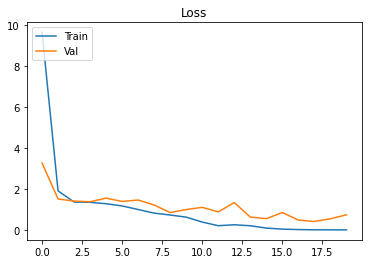

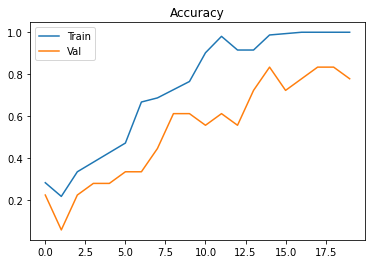

In [49]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [50]:
loss, acc = model.evaluate(image_test, labels_test_onehot)
print("Test Loss", loss)
print("Test Accuracy", acc)

2/2 [==============================] - 0s 19ms/step - loss: 0.3532 - accuracy: 0.8947
Test Loss 0.35320332646369934
Test Accuracy 0.8947368264198303


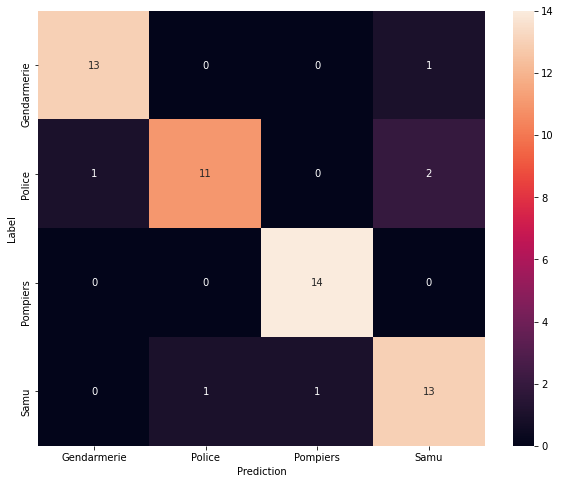

In [51]:
y_pred = np.argmax(model.predict(image_test), axis=1)

yy = []
for i in range(0,len(target_test_s)):
    if target_test_s[i] == 'Gendarmerie':
        yy.append(0)
    if target_test_s[i] == 'Police':
        yy.append(1)
    if target_test_s[i] == 'Pompiers':
        yy.append(2)
    if target_test_s[i] == 'Samu':
        yy.append(3)

commands = []
commands.append('Gendarmerie')
commands.append('Police')
commands.append('Pompiers')
commands.append('Samu')

y_true = yy

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()